<a href="https://colab.research.google.com/github/innosoft21/workspace/blob/main/tensorflow_python2/1_1_2_Multi_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi-output Model

두 개 이상의 출력으로 모델을 제작하는 방법을 보여드리겠습니다. 

우리가 연구할 데이터 세트는 UCI 기계 학습 저장소에서 이용할 수 있다. 

이 데이터 세트는 구성물 (예: 벽면 영역, 지붕 영역)을 입력으로 사용하고 두 가지 출력(냉각 부하 및 난방 부하)을 갖는 에너지 효율 데이터 세트입니다. 

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

Utilities

우리는 코드를 보다 깔끔하게 만들기 위해 데이터 변환 및 시각화를 위한 몇 가지 유틸리티를 정의한다.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

Prepare the Data

우리는 데이터 세트를 다운로드하고 훈련을 위해 포맷한다.

In [4]:
# Specify data URI
URI = '/content/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

Build the Model

다음은 기능 구문을 사용하여 모델을 작성하는 방법입니다. model() 클래스를 인스턴스화할 때 출력 목록(예: [y1_output, y2_output])을 지정할 수 있습니다.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

Configure parameters

각 출력에 대한 loss 및 metric뿐만 아니라 optimizer도 지정합니다.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 4s 7ms/step - loss: 568.8703 - y1_output_loss: 276.1377 - y2_output_loss: 292.7325 - y1_output_root_mean_squared_error: 15.9792 - y2_output_root_mean_squared_error: 16.4318 - val_loss: 53.6210 - val_y1_output_loss: 18.6508 - val_y2_output_loss: 34.9702 - val_y1_output_root_mean_squared_error: 4.3187 - val_y2_output_root_mean_squared_error: 5.9136
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 35.1104 - y1_output_loss: 13.0198 - y2_output_loss: 22.0907 - y1_output_root_mean_squared_error: 3.6024 - y2_output_root_mean_squared_error: 4.6925 - val_loss: 32.5590 - val_y1_output_loss: 14.2536 - val_y2_output_loss: 18.3054 - val_y1_output_root_mean_squared_error: 3.7754 - val_y2_output_root_mean_squared_error: 4.2785
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 25.0167 - y1_output_loss: 10.8099 - y2_output_loss: 14.2068 - y1_output_root_mean_squared_error: 3.2794 - y2_output_root_mean_sq

Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 1.4732 - y1_output_loss: 0.2760 - y2_output_loss: 1.1972 - y1_output_root_mean_squared_error: 0.5254 - y2_output_root_mean_squared_error: 1.0942
Loss = 1.4731934070587158, Y1_loss = 0.2760217785835266, Y1_mse = 0.5253777503967285, Y2_loss = 1.1971715688705444, Y2_mse = 1.0941534042358398


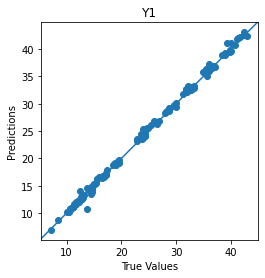

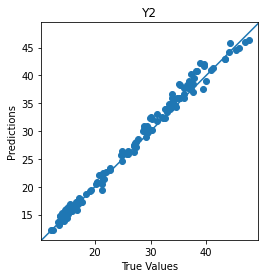

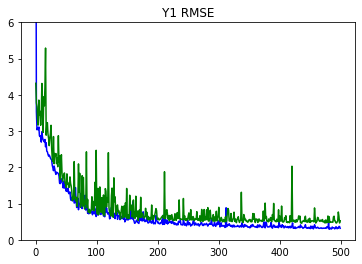

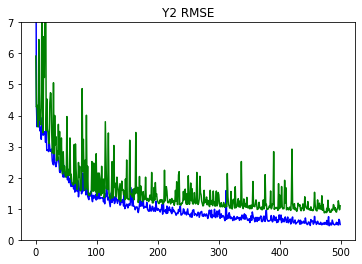

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)